# Non-Negative Matrix Factorization for Muscle Synergy Extraction

This program performs Non-Negative Matrix Factorization for determining
the appropriate number of components/muscle channels to use for muscle
synergy extraction.

Some functions could be more recursive however, they have been used in
applications such as synergy selection.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy import ndimage, signal, interpolate
from sklearn.decomposition import NMF

# Functions

Below are some function relating to synergy analysis

In [3]:
def nnmf_factorize(A, k):
    """Non-Negative Matrix Factorization for Muscle Synergy Extraction
    @param A: input matrix
    @param k: number of components (muscle channels)

    @return W: motor primitives
    @return H: motor modules
    @return C: factorized matrix
    """
    nmf = NMF(n_components=k, init='random', random_state=0)
    W = nmf.fit_transform(A)
    H = nmf.components_
    C = np.dot(W, H)
    return W, H, C

def synergy_extraction(data_input, synergy_selection):
    """Synergy Extraction from factorized matricies
    @param data_input: path to csv data file
    @param synergy_selection:

    @return W: motor primitives
    @return H: motor modules
    """

    # Load Data
    data = pd.read_csv(data_input, header=None)
    A = data.to_numpy()

    # Choosing best number of components
    chosen_synergies = synergy_selection
    W, H, C = nnmf_factorize(A, chosen_synergies)

    motor_modules = H
    motor_primitives = W

    return motor_primitives, motor_modules

def read_all_csv(directory_path):
    data_dict = {}  # Initialize an empty dictionary to store the data

    if not os.path.isdir(directory_path):
        print(f"{directory_path} is not a valid directory.")
        return

    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            data = pd.read_csv(file_path)
            data_dict[filename] = data

    return data_dict



def full_width_half_first_min(motor_p_full, synergy_selection):
    """Full width half maxiumum calculation
    @param: motor_p_full: full length numpy array of selected motor
    primitives

    @return: mean_fwhm: Mean value for the width of the primitives
    """

    number_cycles = len(motor_p_full) // 200

    # Save
    fwhl = np.array([])
    half_width_height_array = np.array([])
    fwhl_start_stop = np.empty((number_cycles, 0))

    for i in range(number_cycles):
        current_primitive = motor_p_full[i * 200: (i + 1) * 200, synergy_selection - 2]

        primitive_mask = current_primitive > 0.0

        # applying mask to exclude values which were subject to rounding errors
        mcurrent_primitive = np.asarray(current_primitive[primitive_mask])

        # Dealing with local maxima issues at ends of primitives
        # diff_mcurrent = np.diff(mcurrent_primitive_full, axis=0)
        # mcurrent_primitive = mcurrent_primitive_full[np.arange(mcurrent_primitive_full.shape[0]), diff_mcurrent]

        abs_min_ind = np.argmin(mcurrent_primitive)

        # getting maximum
        max_ind = np.argmax(mcurrent_primitive[abs_min_ind + 1:]) + (abs_min_ind - 1)

        # getting the minimum before
        # min_ind_before = np.argmin(mcurrent_primitive[:max_ind])

        # getting the minimum index after maximum
        # Making sure to include the max after so the index for the whole array
        min_ind_after = np.argmin(mcurrent_primitive[max_ind + 1:]) + (max_ind - 1)

        half_width_height = (mcurrent_primitive[max_ind] - mcurrent_primitive[abs_min_ind]) / 2
        # largest_index = np.argmax(arr[np.logical_and(arr > 2, arr < 8)])
        # Getting the closest indicies on either side of the max closest to half width
        half_width_start = np.argmax(mcurrent_primitive[::max_ind] > half_width_height)
        half_width_end = np.argmax(mcurrent_primitive[:max_ind] > half_width_height)

        # area_above_half = [i for i in range(len(mcurrent_primitive)) if mcurrent_primitive[i] > half_width_height]
        # half_width_start = area_above_half[0]
        # half_width_end = area_above_half[-1]

        # Adding start and stop coordinates appropriate to array
        half_width_height_array = np.append(half_width_height_array, [half_width_height])
        # fwhl_height = fwhl_start_stop_list.reshape((len(fwhl_start_stop_list) // 2), 2)
        fwhl_start_stop = np.append(fwhl_start_stop, [[half_width_start, half_width_end]])
        fwhl_start_stop = fwhl_start_stop.reshape((len(fwhl_start_stop) // 2), 2)

        # Determing length for primitive and appending
        full_width_length = half_width_end - half_width_start
        fwhl = np.append(fwhl, [full_width_length])

        print("Start of half width line", half_width_start)
        print("End of half width line", half_width_end)

        # # print("Half width height", half_width_height)

        # print("before max min index", min_ind_before, "value", mcurrent_primitive[min_ind_before])
        print("half width height", half_width_height)
        print("max value", max_ind, "value", mcurrent_primitive[max_ind])
        print("min value", abs_min_ind, "value", mcurrent_primitive[abs_min_ind])
        print("after max min value", min_ind_after, "value", mcurrent_primitive[min_ind_after])
        print("Length", full_width_length)
        print(mcurrent_primitive[min_ind_after])
        print()


    return fwhl, fwhl_start_stop, half_width_height_array

def full_width_half_abs_min(motor_p_full, synergy_selection):
    """Full width half maxiumum calculation
    @param: motor_p_full_full: full length numpy array of selected motor
    primitives

    @return: mean_fwhm: Mean value for the width of the primitives
    """

    number_cycles = len(motor_p_full) // 200

    # Save
    fwhl = np.array([])
    half_width_height_array = np.array([])
    fwhl_start_stop = np.empty((number_cycles, 0))

    for i in range(number_cycles):
        current_primitive = motor_p_full[i * 200: (i + 1) * 200, synergy_selection - 2]

        primitive_mask = current_primitive > 0.0

        # applying mask to exclude values which were subject to rounding errors
        mcurrent_primitive = np.asarray(current_primitive[primitive_mask])

        # getting maximum
        max_ind = np.argmax(mcurrent_primitive)

        # abs_min_ind = np.argmin(mcurrent_primitive)
        # getting the minimum before
        min_ind_before = np.argmin(mcurrent_primitive[:max_ind])

        # getting the minimum index after maximum
        # Making sure to include the max after so the index for the whole array
        min_ind_after = np.argmin(mcurrent_primitive[max_ind + 1:]) + (max_ind - 1)

        # Determing the smaller minimum to use
        if mcurrent_primitive[min_ind_before] < mcurrent_primitive[min_ind_after]:
            # print("First minimum used!")

            # Half Width formula
            half_width_height = (mcurrent_primitive[max_ind] - mcurrent_primitive[min_ind_before]) / 2

            half_width_start = np.argmax(mcurrent_primitive[::max_ind] < half_width_height) + min_ind_before
            half_width_end = np.argmax(mcurrent_primitive[:max_ind] > half_width_height)
        else:
            # print("Second minimum used")
            half_width_height = (mcurrent_primitive[max_ind] - mcurrent_primitive[min_ind_after]) / 2

        # largest_index = np.argmax(arr[np.logical_and(arr > 2, arr < 8)])
        # Getting the closest indicies on either side of the max closest to half width
        # half_width_start = np.argmax(mcurrent_primitive[::max_ind] > half_width_height)
        # half_width_end = np.argmax(mcurrent_primitive[:max_ind] > half_width_height)
        # half_width_height = (max_ind - abs_min_ind) / 2

        area_above_half = [i for i in range(len(mcurrent_primitive)) if mcurrent_primitive[i] > half_width_height]
        half_width_start = area_above_half[0]
        half_width_end = area_above_half[-1]

        # Adding start and stop coordinates appropriate to array
        half_width_height_array = np.append(half_width_height_array, [half_width_height])
        # fwhl_height = fwhl_start_stop_list.reshape((len(fwhl_start_stop_list) // 2), 2)
        fwhl_start_stop = np.append(fwhl_start_stop, [[half_width_start, half_width_end]])
        fwhl_start_stop = fwhl_start_stop.reshape((len(fwhl_start_stop) // 2), 2)

        # Determing length for primitive and appending
        full_width_length = half_width_end - half_width_start
        fwhl = np.append(fwhl, [full_width_length])

        # print("Start of half width line", half_width_start)
        # print("End of half width line", half_width_end)

        # # # print("Half width height", half_width_height)

        # print("before max min index", min_ind_before, "value", mcurrent_primitive[min_ind_before])
        # print("half width height", half_width_height)
        # print("max value", max_ind, "value", mcurrent_primitive[max_ind])
        # print("after max min value", min_ind_after, "value", mcurrent_primitive[min_ind_after])
        # print("Length", full_width_length)
        # print(mcurrent_primitive[min_ind_after])
        # print()


    return fwhl, fwhl_start_stop, half_width_height_array

def full_width_half_abs_min_scipy(motor_p_full, synergy_selection):
    """Full width half maxiumum calculation
    @param: motor_p_full_full: full length numpy array of selected motor
    primitives

    @return: mean_fwhm: Mean value for the width of the primitives
    """

    number_cycles = len(motor_p_full) // 200

    # Save
    fwhl = np.array([])

    for i in range(number_cycles):
        current_primitive = motor_p_full[i * 200: (i + 1) * 200, synergy_selection - 2]

        # primitive_mask = current_primitive > 0.0

        # # applying mask to exclude values which were subject to rounding errors
        # mcurrent_primitive = np.asarray(current_primitive[primitive_mask])

        # Find peaks
        peaks, properties = signal.find_peaks(current_primitive, distance=40, width=3)
        max_ind = np.argmax(peaks)
        # min_ind = np.argmin(mcurrent_primitive[0:max_ind])

        # half_width_height = (mcurrent_primitive[max_ind] - mcurrent_primitive[min_ind]) / 2

        # print("Manually Calculated", half_width_height)
        fwhl = properties["widths"][max_ind]
        print(fwhl)

        print("Scipy calculated", properties['widths'][max_ind])
        # print(peaks[max_ind])

    return fwhl
# Plotting Section
def sel_primitive_trace(motor_primitives, synergy_selection, selected_primitive_title="Output"):
    """This will plot the selected motor primitives
    @param data_input: path to csv data file
    @param synergy_selection: how many synergies you want

    @return null
    """

    # motor_primitives, motor_modules = synergy_extraction(data_input, synergy_selection)

    # Smoothen the data

    # fwhl, fwhl_start_stop, fwhl_height = full_width_half_abs_min(motor_primitives, synergy_selection)

    samples = np.arange(0, len(motor_primitives))
    samples_binned = np.arange(200)
    number_cycles = len(motor_primitives) // 200

    # Plot
    primitive_trace = np.zeros(200)
    fwhl = []

    # Plotting Primitive Selected Synergy Count

    # Iterate over the bins
    for i in range(number_cycles):
        # Get the data for the current bin

        time_point_average = motor_primitives[i * 200: (i + 1) * 200, synergy_selection - 1]

        # fwhl_line_start = fwhl_start_stop[i, 0]
        # fwhl_line_stop = fwhl_start_stop[i, 1]
        # plt.hlines(fwhl_height[i], fwhl_line_start, fwhl_line_stop, color='black', alpha=0.2)
        # Accumulate the trace values
        current_primitive = motor_primitives[i * 200: (i + 1) * 200, synergy_selection - 1]
        plt.plot(samples[samples_binned], current_primitive, color='black', alpha=0.2)
        peaks, properties = signal.find_peaks(current_primitive, distance=40, width=10)
        max_ind = np.argmax(peaks)
        # print(properties['widths'][max_ind])
        max_width = properties['widths'][max_ind]
        fwhl.append(max_width)

        plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
            xmax=properties["right_ips"], color = "black", alpha=0.2)
        primitive_trace += time_point_average

    # Calculate the average by dividing the accumulated values by the number of bins
    primitive_trace /= number_cycles

    # peaks, properties = signal.find_peaks(primitive_trace, distance=40, width=15)
    # max_ind = np.argmax(peaks)

    # plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           # xmax=properties["right_ips"], color = "C1")

    plt.plot(samples[samples_binned], primitive_trace, color='blue')

    # Plotting individual primitives in the background
    # selected_primitive = motor_primitives[:, synergy_selection - 2]

    # Using the order F so the values are in column order
    # binned_primitives_raw = selected_primitive.reshape((200, -1), order='F')
    # binned_primitives = ndimage.median_filter(binned_primitives_raw, size=3)
    # plt.plot(binned_primitives_raw[:, i], color='black', alpha=0.2)
    # plt.plot(binned_primitives_raw, color='black', alpha=0.2)
    # print(fwhl_start_stop[3, 1])

    # Removing axis values
    plt.xticks([])
    plt.yticks([])

    # Add a vertical line at the halfway point
    plt.axvline(x=100, color='black')

    # Adding a horizontal line for fwhl

    # fwhl_line_start = np.mean(fwhl_start_stop[:, 0])
    # fwhl_line_stop = np.mean(fwhl_start_stop[:, 1])
    # plt.hlines(y=np.mean(fwhl_height), xmin=fwhl_line_start, xmax=fwhl_line_stop, color='red')

    # Add labels for swing and stance
    plt.text(50, -0.2 * np.max(primitive_trace), 'Swing', ha='center', va='center')
    plt.text(150, -0.2 * np.max(primitive_trace), 'Stance', ha='center', va='center')

    # Removing top and right spines of the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)
    plt.title(selected_primitive_title, fontsize=16, fontweight='bold')
    # plt.savefig(selected_primitive_filename, dpi=300)
    plt.show()
    
    fwhl = np.asarray(fwhl)
    print(fwhl)

    return fwhl



# Main Analysis

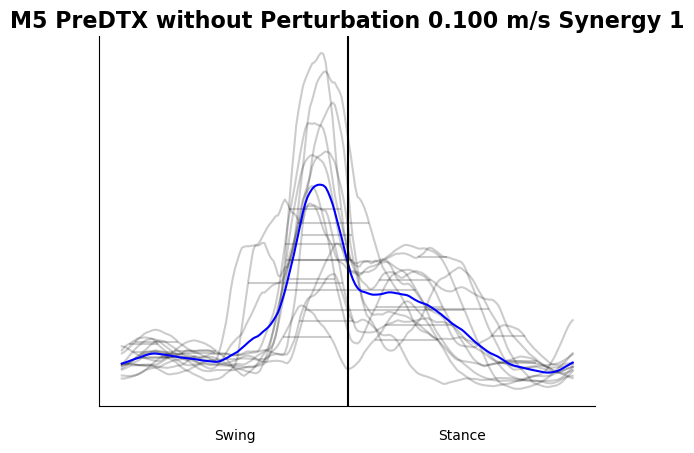

[14.68712217 12.72349476 29.42627322 58.90527273 70.08952871 22.85590125
 14.64821429 28.272873   28.19569493 16.94799331 27.91241262 23.60285723]


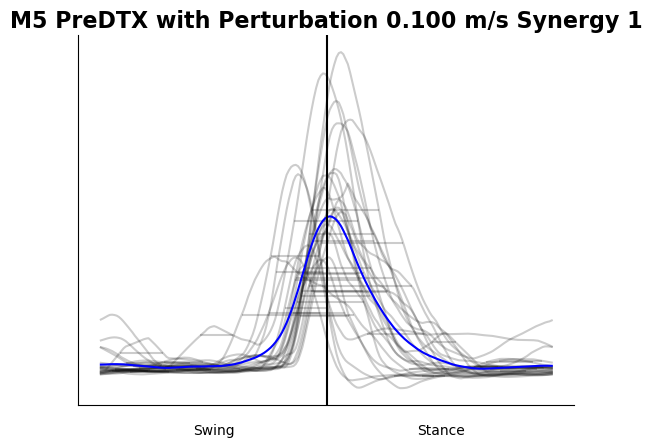

[28.16421968 24.99564259 45.22589555 28.43273243 18.76420582 17.61259707
 20.78070175 26.9668851  17.44746163 21.67909872 10.1952381  37.91565865
 11.16964286 10.52307292 20.79312997 15.65177833 32.03591483 28.12201964
 12.57856946 28.32168869 30.51294519 22.81580881 20.48824897]


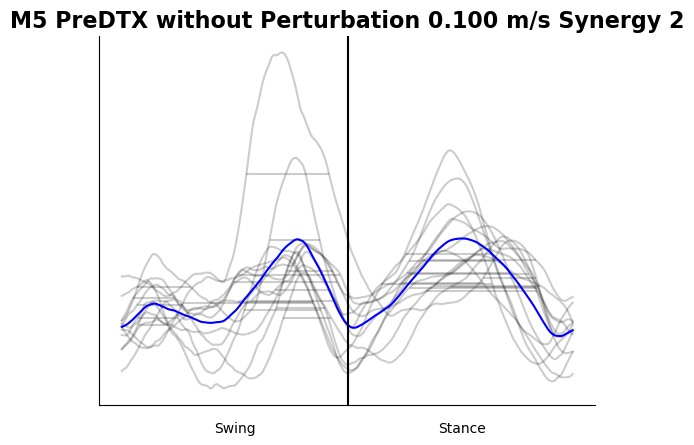

[23.56328965 48.99757506 56.77710878 35.9776631  49.03270661 53.30035738
 45.20603009 50.2773516  37.41111312 46.54565488 38.68857569 37.7965464 ]


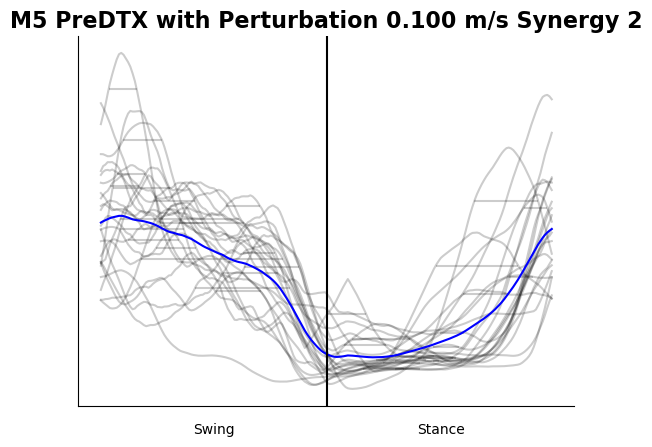

[16.9435137  10.554942   10.73151556 12.98606115 28.04749618 19.63160477
 16.13782696 11.16245905 18.10470085 10.490949   11.25402985 19.20911534
 16.46529333 12.53985885 25.72111332 36.4455394  17.33415617 27.90729235
 19.57351671 18.28605298 19.53047264 21.65576418 25.42682174]


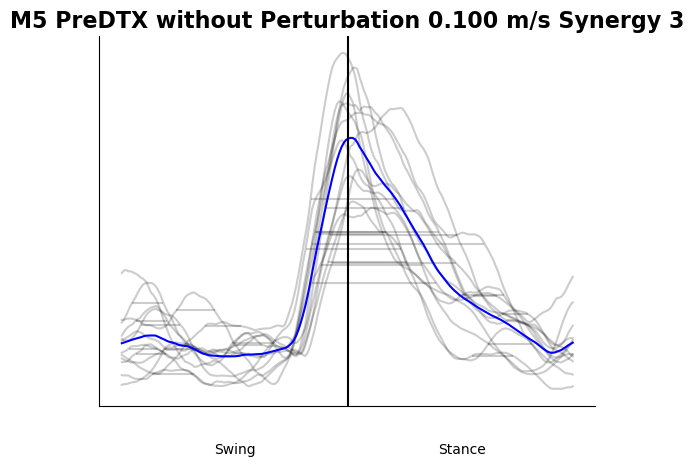

[76.15766071 11.47948383 34.80227277 18.20057716 28.82380226 36.70052362
 10.95547464 18.2829347  56.24908257 54.658734   19.53186024 44.35884878]


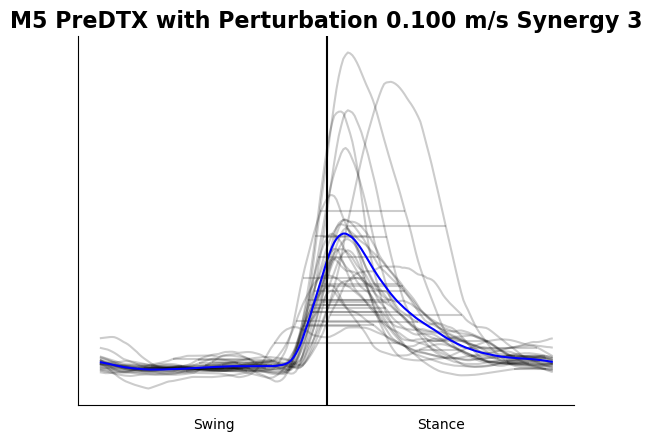

[14.40643175 13.93784029 30.91657342 16.20509709 43.49430888 29.72550029
 22.88366836 36.08730762 19.66883963 37.46901503 21.52137931 42.4251534
 31.30212205 31.57084442 38.80100575 17.90458613 58.31953902 10.04210526
 32.56695482 29.9440899  17.28511236 26.7223632  40.26602819]


In [4]:
# For preDTX primitives
synergy_selection = 1
motor_p_data_non = pd.read_csv('./predtx-non-primitives.txt', header=None)
motor_p_preDTX_non = motor_p_data_non.to_numpy()

motor_p_data_per = pd.read_csv('./predtx-per-primitives.txt', header=None)
motor_p_preDTX_per = motor_p_data_per.to_numpy()

fwhl_non_syn1 = sel_primitive_trace(motor_p_preDTX_non, synergy_selection, "M5 PreDTX without Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

fwhl_per_syn1 = sel_primitive_trace(motor_p_preDTX_per, synergy_selection, "M5 PreDTX with Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

synergy_selection = 2
motor_p_data_non = pd.read_csv('./predtx-non-primitives.txt', header=None)
motor_p_preDTX_non = motor_p_data_non.to_numpy()

motor_p_data_per = pd.read_csv('./predtx-per-primitives.txt', header=None)
motor_p_preDTX_per = motor_p_data_per.to_numpy()

fwhl_non_syn2 = sel_primitive_trace(motor_p_preDTX_non, synergy_selection, "M5 PreDTX without Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

fwhl_per_syn2 = sel_primitive_trace(motor_p_preDTX_per, synergy_selection, "M5 PreDTX with Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

synergy_selection = 3
motor_p_data_non = pd.read_csv('./predtx-non-primitives.txt', header=None)
motor_p_preDTX_non = motor_p_data_non.to_numpy()

motor_p_data_per = pd.read_csv('./predtx-per-primitives.txt', header=None)
motor_p_preDTX_per = motor_p_data_per.to_numpy()

fwhl_non_syn3 = sel_primitive_trace(motor_p_preDTX_non, synergy_selection, "M5 PreDTX without Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

fwhl_per_syn3 = sel_primitive_trace(motor_p_preDTX_per, synergy_selection, "M5 PreDTX with Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

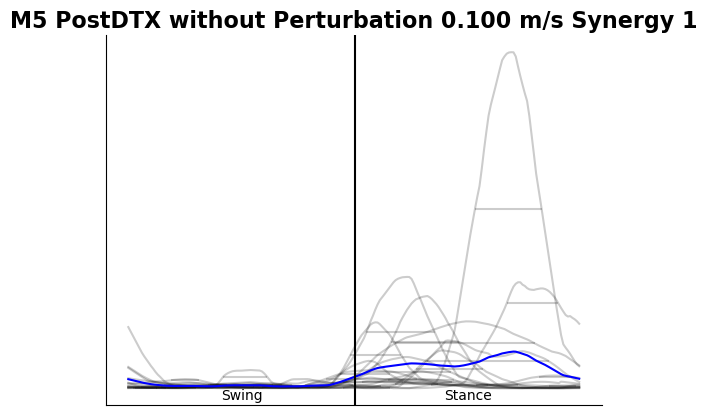

[29.18610747 22.63529081 22.29649513 30.20643534 25.30078947 61.6121012
 29.75386185 37.77696422 12.14722222 53.76868621 29.4604826  13.90183461
 18.55994152 29.28105758 48.1640923 ]


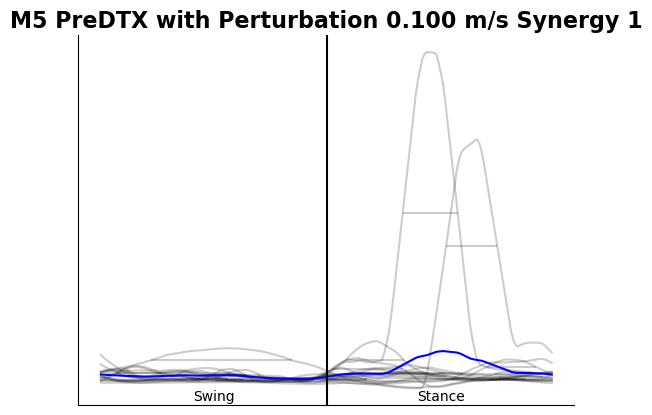

[33.10931526 55.10720504 62.177404   20.26885352 12.2688057  24.26698076
 25.39539197 16.2172077  21.86226936 32.92569147 19.45111529 22.50338284
 15.18420757 42.58735904 19.38204941]


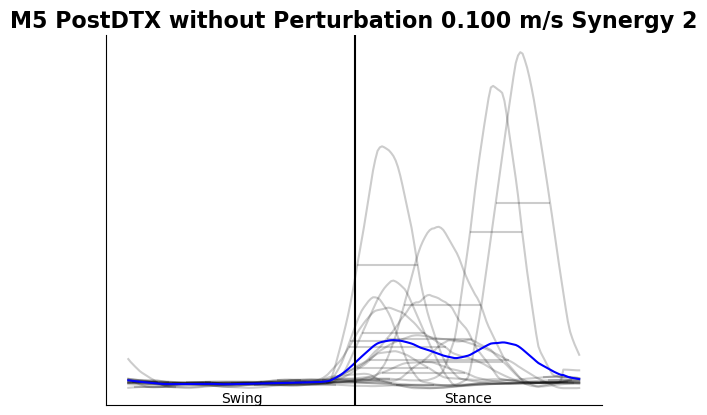

[19.25       24.0735763  25.47121212 26.64679181 12.625      61.43474259
 37.39447078 31.64030809 10.8676236  36.12830281 22.99736422 42.58473048
 12.20683761 33.87424466 29.13366067]


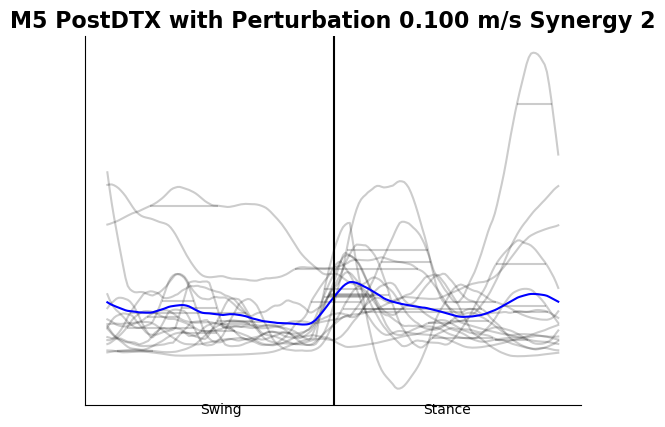

[44.56703415 12.93368308 22.14838509 15.4514881  26.7499275  22.39072261
 16.84535835 22.28893423 19.27414612 15.86941371 53.99828644 15.36603254
 10.21170933 14.55159847 52.8793192 ]


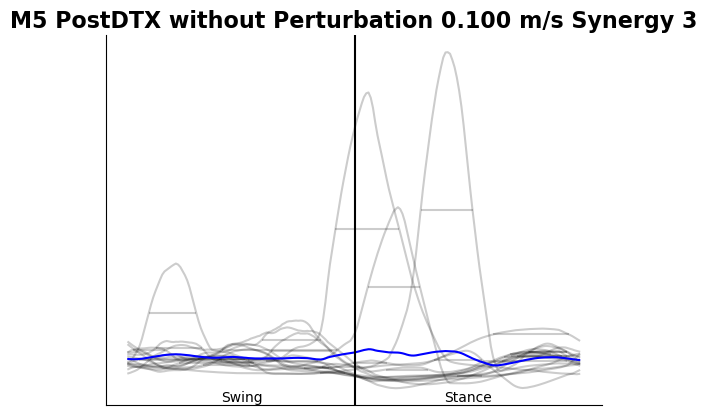

[10.86389961 21.11745276 23.59910321 11.08205128 18.05693779 28.22313691
 22.23664961 33.40372144 28.53813395 18.81060498 16.84668525 17.2185576
 33.61777035 23.01400582 22.14855342]


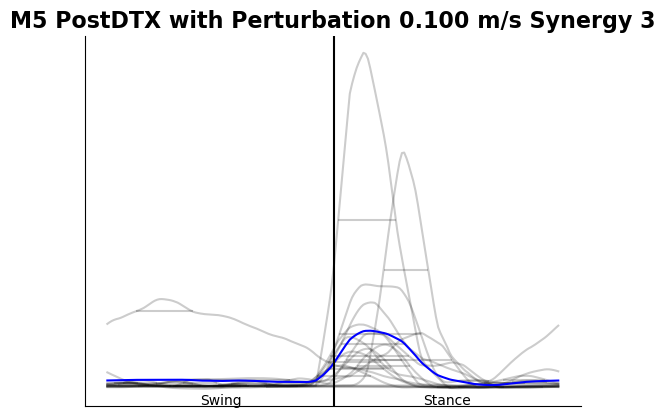

[15.34537815 81.66666667 18.56146252 14.41522556 28.71045365 18.05
 24.42233725 46.38961039 20.10216718 14.91503268 25.19050981 34.52746627
 34.90837457 23.11889398 19.67178921]


In [6]:
# For PostDTX Conditions
synergy_selection = 1
motor_p_data_non_post = pd.read_csv('./postDTX-non-spike-primitives.csv', header=None)
motor_p_preDTX_non_post = motor_p_data_non_post.to_numpy()

motor_p_data_per_post = pd.read_csv('./postDTX-per-spike-primitives.csv', header=None)
motor_p_preDTX_per_post = motor_p_data_per_post.to_numpy()


# fwhl_non_post, fwhl_non_post_start_stop, fwhl_height_non_post = full_width_half_abs_min(motor_p_preDTX_non_post, synergy_selection)
fwhl_post_non_syn1 = sel_primitive_trace(motor_p_preDTX_non_post, synergy_selection, "M5 PostDTX without Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

# fwhl_per_post, fwhl_per_post_start_stop, fwhl_height_per_post = full_width_half_abs_min(motor_p_preDTX_per_post, synergy_selection)
fwhl_post_per_syn1 = sel_primitive_trace(motor_p_preDTX_per_post, synergy_selection, "M5 PreDTX with Perturbation 0.100 m/s Synergy {}".format(synergy_selection))


synergy_selection = 2
motor_p_data_non_post = pd.read_csv('./postDTX-non-spike-primitives.csv', header=None)
motor_p_preDTX_non_post = motor_p_data_non_post.to_numpy()

motor_p_data_per_post = pd.read_csv('./postDTX-per-spike-primitives.csv', header=None)
motor_p_preDTX_per_post = motor_p_data_per_post.to_numpy()


# fwhl_non_post, fwhl_non_post_start_stop, fwhl_height_non_post = full_width_half_abs_min(motor_p_preDTX_non_post, synergy_selection)
fwhl_post_non_syn2 = sel_primitive_trace(motor_p_preDTX_non_post, synergy_selection, "M5 PostDTX without Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

# fwhl_per_post, fwhl_per_post_start_stop, fwhl_height_per_post = full_width_half_abs_min(motor_p_preDTX_per_post, synergy_selection)
fwhl_post_per_syn2 = sel_primitive_trace(motor_p_preDTX_per_post, synergy_selection, "M5 PostDTX with Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

synergy_selection = 3
motor_p_data_non_post = pd.read_csv('./postDTX-non-spike-primitives.csv', header=None)
motor_p_preDTX_non_post = motor_p_data_non_post.to_numpy()

motor_p_data_per_post = pd.read_csv('./postDTX-per-spike-primitives.csv', header=None)
motor_p_preDTX_per_post = motor_p_data_per_post.to_numpy()


# fwhl_non_post, fwhl_non_post_start_stop, fwhl_height_non_post = full_width_half_abs_min(motor_p_preDTX_non_post, synergy_selection)
fwhl_post_non_syn3 = sel_primitive_trace(motor_p_preDTX_non_post, synergy_selection, "M5 PostDTX without Perturbation 0.100 m/s Synergy {}".format(synergy_selection))

# fwhl_per_post, fwhl_per_post_start_stop, fwhl_height_per_post = full_width_half_abs_min(motor_p_preDTX_per_post, synergy_selection)
fwhl_post_per_syn3 = sel_primitive_trace(motor_p_preDTX_per_post, synergy_selection, "M5 PostDTX with Perturbation 0.100 m/s Synergy {}".format(synergy_selection))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.axis.XTick at 0x148f9af90>,
 [Text(0, 0, 'PreDTX Non Syn 1'),
  Text(1, 0, 'PreDTX Non Syn 2'),
  Text(2, 0, 'PreDTX Non Syn 3'),
  Text(3, 0, 'PreDTX Per Syn 1'),
  Text(4, 0, 'PreDTX Per Syn 2'),
  Text(5, 0, 'PreDTX Per Syn 3')])

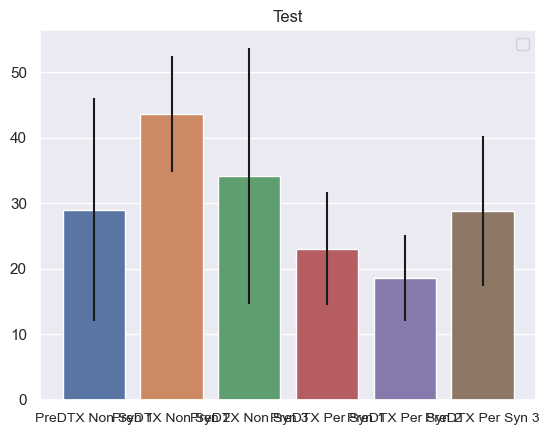

In [7]:
# Analysis of fwhl_lenghts

# PreDTX Results
predtx_results = dict()
predtx_results.update({'PreDTX Non Syn 1': [np.mean(fwhl_non_syn1), np.std(fwhl_non_syn1)]})
predtx_results.update({'PreDTX Non Syn 2': [np.mean(fwhl_non_syn2), np.std(fwhl_non_syn2)]})
predtx_results.update({'PreDTX Non Syn 3': [np.mean(fwhl_non_syn3), np.std(fwhl_non_syn3)]})
predtx_results.update({'PreDTX Per Syn 1': [np.mean(fwhl_per_syn1), np.std(fwhl_per_syn1)]})
predtx_results.update({'PreDTX Per Syn 2': [np.mean(fwhl_per_syn2), np.std(fwhl_per_syn2)]})
predtx_results.update({'PreDTX Per Syn 3': [np.mean(fwhl_per_syn3), np.std(fwhl_per_syn3)]})

# sns.set()
mean_fwhl_predtx = [value[0] for value in predtx_results.values()]
std_fwhl_predtx = [value[1] for value in predtx_results.values()]

# PostDTX Results
postdtx_results = dict()
postdtx_results.update({'PostDTX Non Syn 1': [np.mean(fwhl_post_non_syn1), np.std(fwhl_post_non_syn1)]})
postdtx_results.update({'PostDTX Non Syn 2': [np.mean(fwhl_post_non_syn2), np.std(fwhl_post_non_syn2)]})
postdtx_results.update({'PostDTX Non Syn 3': [np.mean(fwhl_post_non_syn3), np.std(fwhl_post_non_syn3)]})
postdtx_results.update({'PostDTX Per Syn 1': [np.mean(fwhl_post_per_syn1), np.std(fwhl_post_per_syn1)]})
postdtx_results.update({'PostDTX Per Syn 2': [np.mean(fwhl_post_per_syn2), np.std(fwhl_post_per_syn2)]})
postdtx_results.update({'PostDTX Per Syn 3': [np.mean(fwhl_post_per_syn3), np.std(fwhl_post_per_syn3)]})

mean_fwhl_postdtx = [value[0] for value in predtx_results.values()]
std_fwhl_postdtx = [value[1] for value in predtx_results.values()]

# Plotting
sns.set()
predtx_trials = list(predtx_results.keys())
postdtx_trials = list(postdtx_results.keys())
fig, ax = plt.subplots(1,1)
plt.title("Test")
plt.legend(loc='upper right', bbox_to_anchor=(1,1))
ax = sns.barplot(x=predtx_trials, y=mean_fwhl_predtx)
ax.errorbar(x=predtx_trials, y=mean_fwhl_predtx, yerr=std_fwhl_predtx, fmt="none", c="k")
# plt.bar(predtx_trials, mean_fwhl_predtx, yerr=std_fwhl_predtx, capsize=3)
plt.xticks(range(len(predtx_trials)), predtx_trials, size='small')